In [1]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


# 数据展示

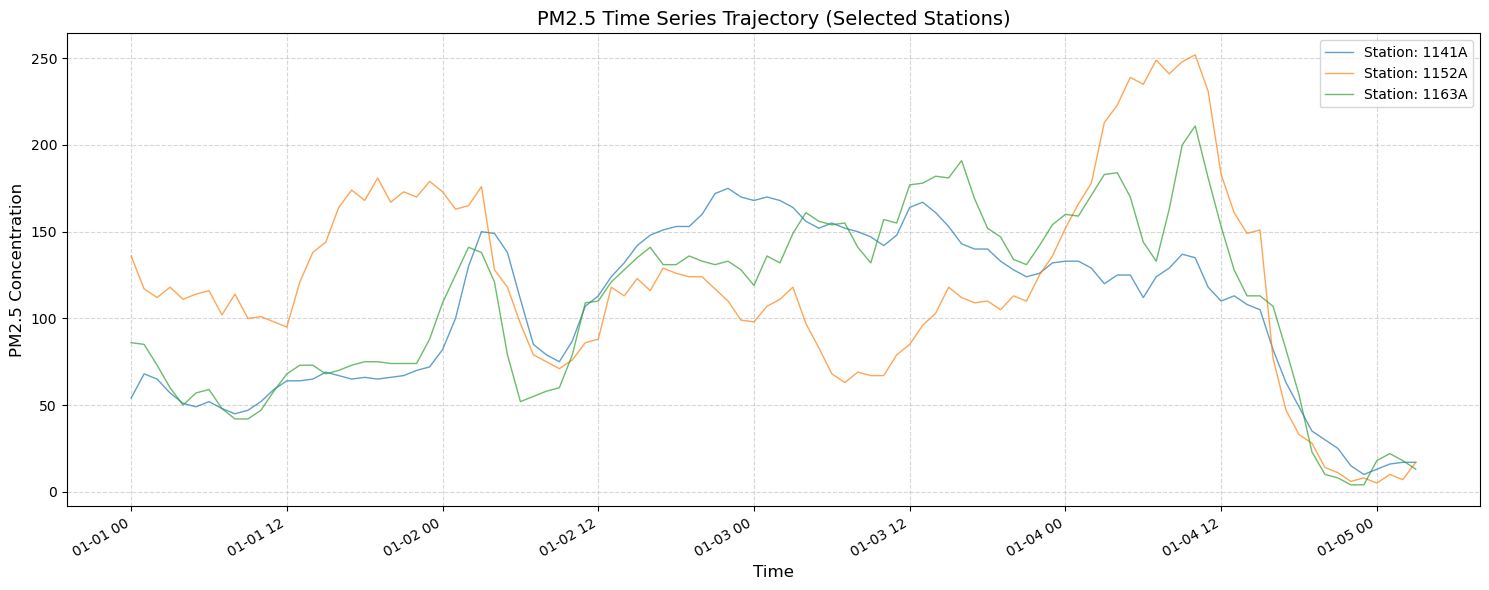

In [2]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data = pm25.isel(station=idx).values
    
    plt.plot(times[:100], station_data[:100], label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('PM2.5 Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
x_data = pm25.values
x_data.shape

(70128, 127)

In [38]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide #+ fourier #custom_library

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(70128, 127)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x106', 'x107', 'x108', 'x109', 'x110', 'x111', 'x112', 'x113', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126']


In [39]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=True
if discrete_time:
    dt = 1
else:
    dt = 1#np.array(range(x_data_lift.shape[0]))

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.001, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.004, max_iter=1000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=False)

optimizer = sr3_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)[k+1] = 0.531 x0[k] + -0.015 x1[k] + 0.065 x2[k] + -0.023 x3[k] + 0.065 x4[k] + 0.053 x5[k] + 0.021 x6[k] + -0.015 x7[k] + 0.013 x8[k] + 0.004 x9[k] + -0.011 x10[k] + 0.017 x11[k] + -0.012 x12[k] + 0.018 x13[k] + -0.004 x14[k] + -0.010 x15[k] + 0.005 x16[k] + 0.006 x17[k] + -0.020 x18[k] + -0.017 x19[k] + -0.018 x20[k] + 0.009 x21[k] + 0.008 x22[k] + 0.023 x23[k] + 0.013 x24[k] + -0.012 x25[k] + 0.039 x26[k] + 0.006 x27[k] + 0.026 x28[k] + -0.012 x29[k] + 0.011 x30[k] + -0.011 x31[k] + -0.010 x32[k] + 0.027 x33[k] + -0.016 x34[k] + -0.007 x35[k] + -0.018 x36[k] + 0.006 x37[k] + 0.015 x38[k] + -0.002 x39[k] + 0.020 x40[k] + 0.015 x41[k] + 0.008 x42[k] + -0.002 x43[k] + -0.002 x44[k] + 0.008 x45[k] + -0.015 x46[k] + 0.006 x47[k] + 0.008 x48[k] + -0.007 x49[k] + -0.006 x50[k] + -0.011 x51[k] + -0.013 x52[k] + -0.005 x53[k] + -0.006 x54[k] + -0.002 x55[k] + -0.016 x56[k] + 0.004 x57[k] + -0.008 x58[k] + -0.005 x59[k] + 0.008 x61[k] + 0.018 x62[k] + -0.003 x63[k] + 0.014 x64[k] + 0.014 

In [40]:
model.score(x_data_lift, t=dt)

0.9438696131484698

In [41]:
step_pred = 5
t = range(step_pred)
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 127)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_12208/2308130201.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


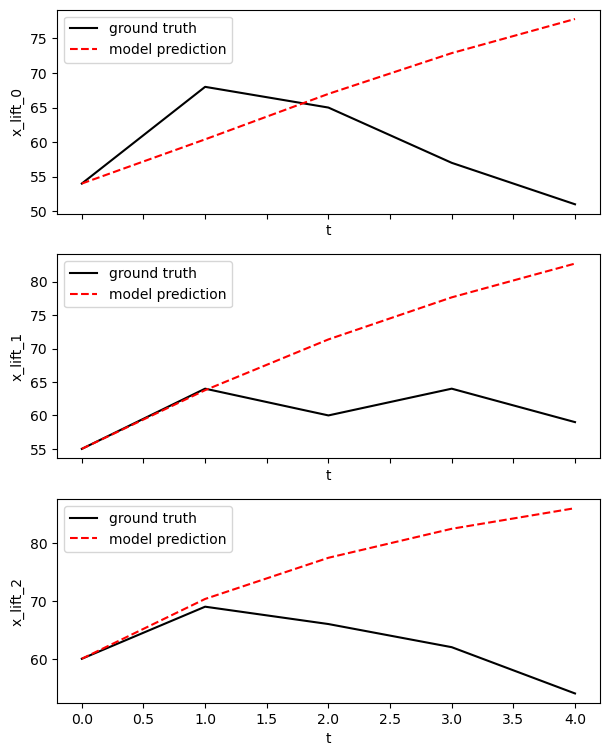

In [42]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

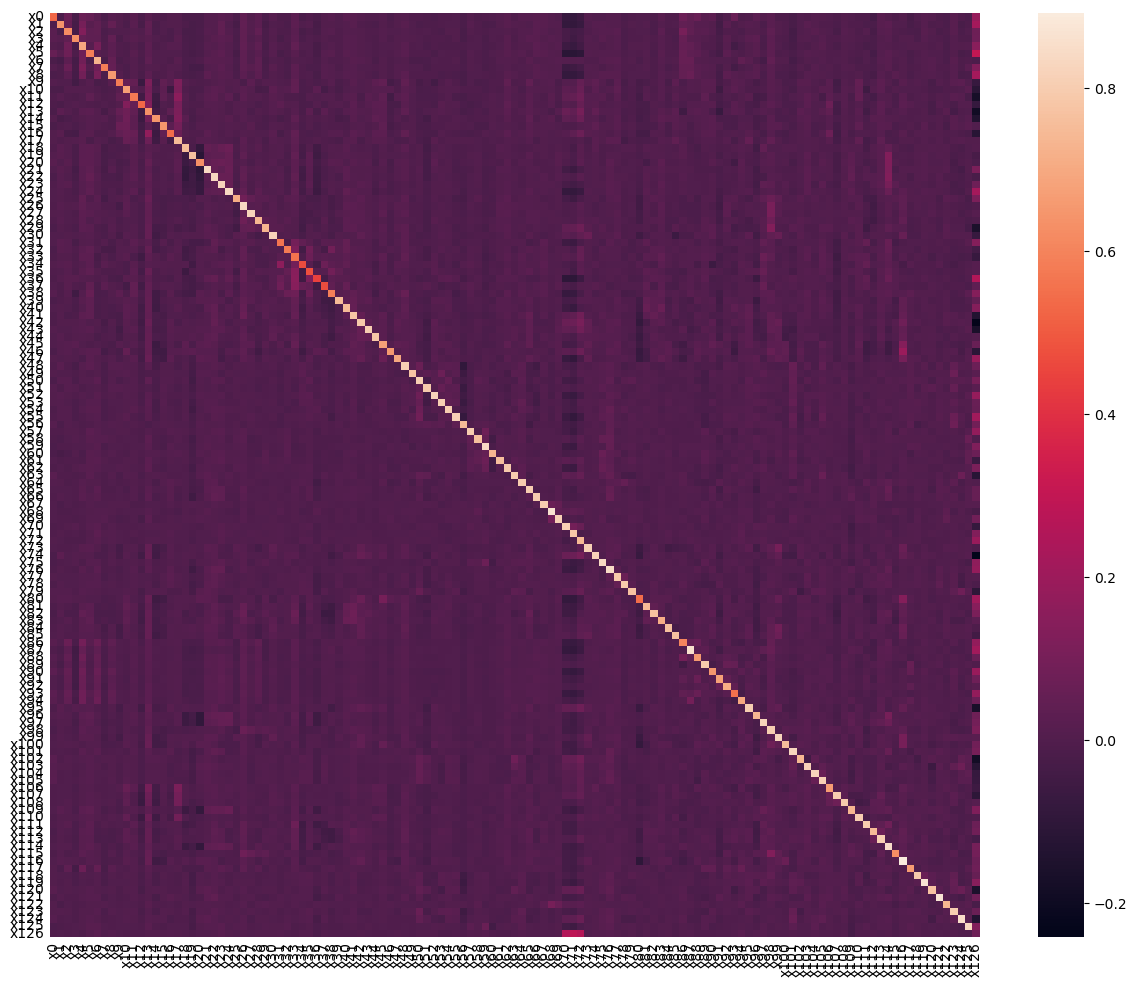

In [43]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

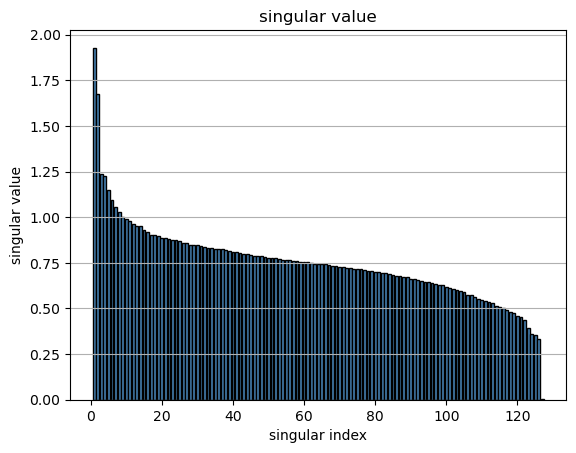

In [44]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

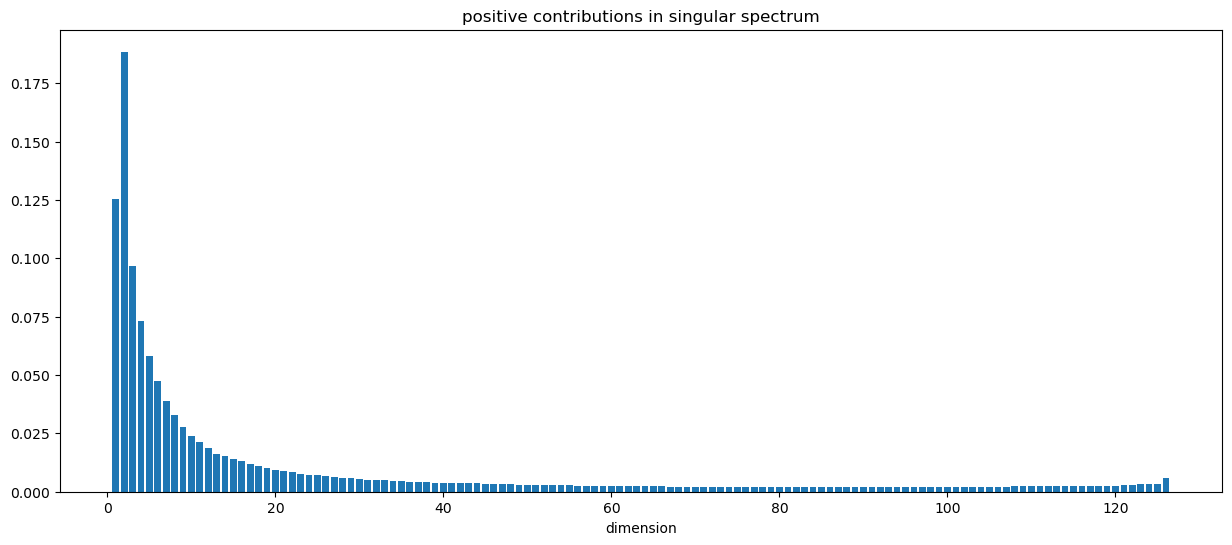

In [45]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [46]:
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

1.0540226325789428


In [47]:
print(compute_entropy(diff))

5.346012354534826


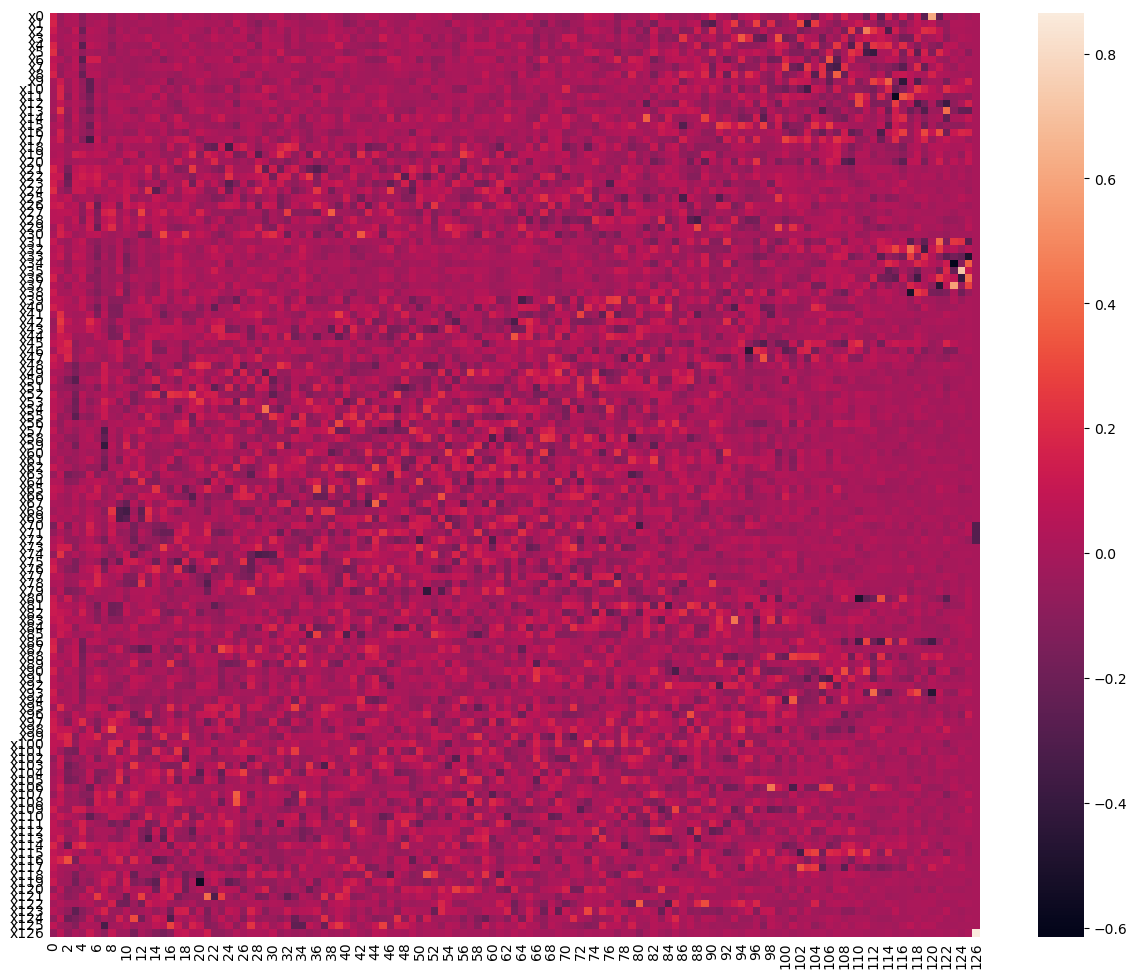

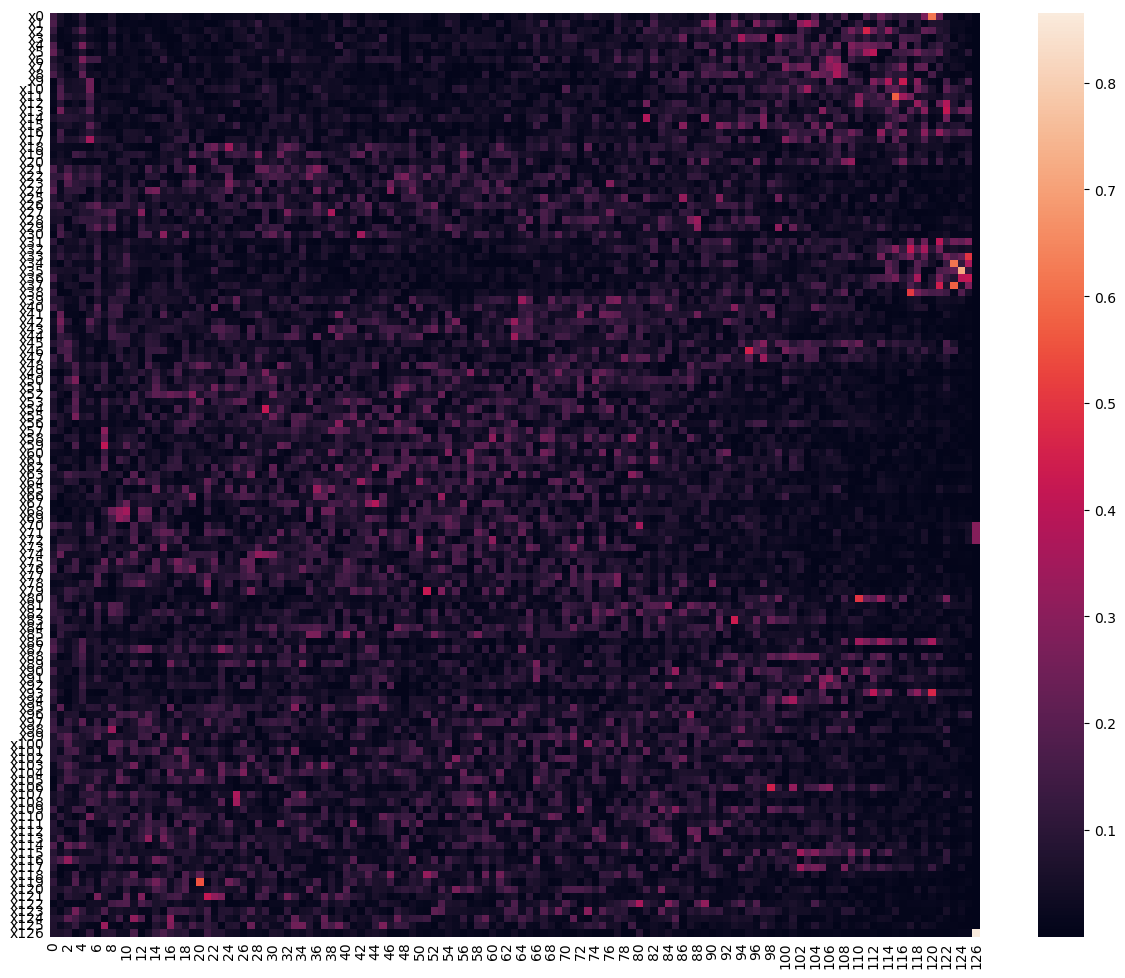

In [48]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

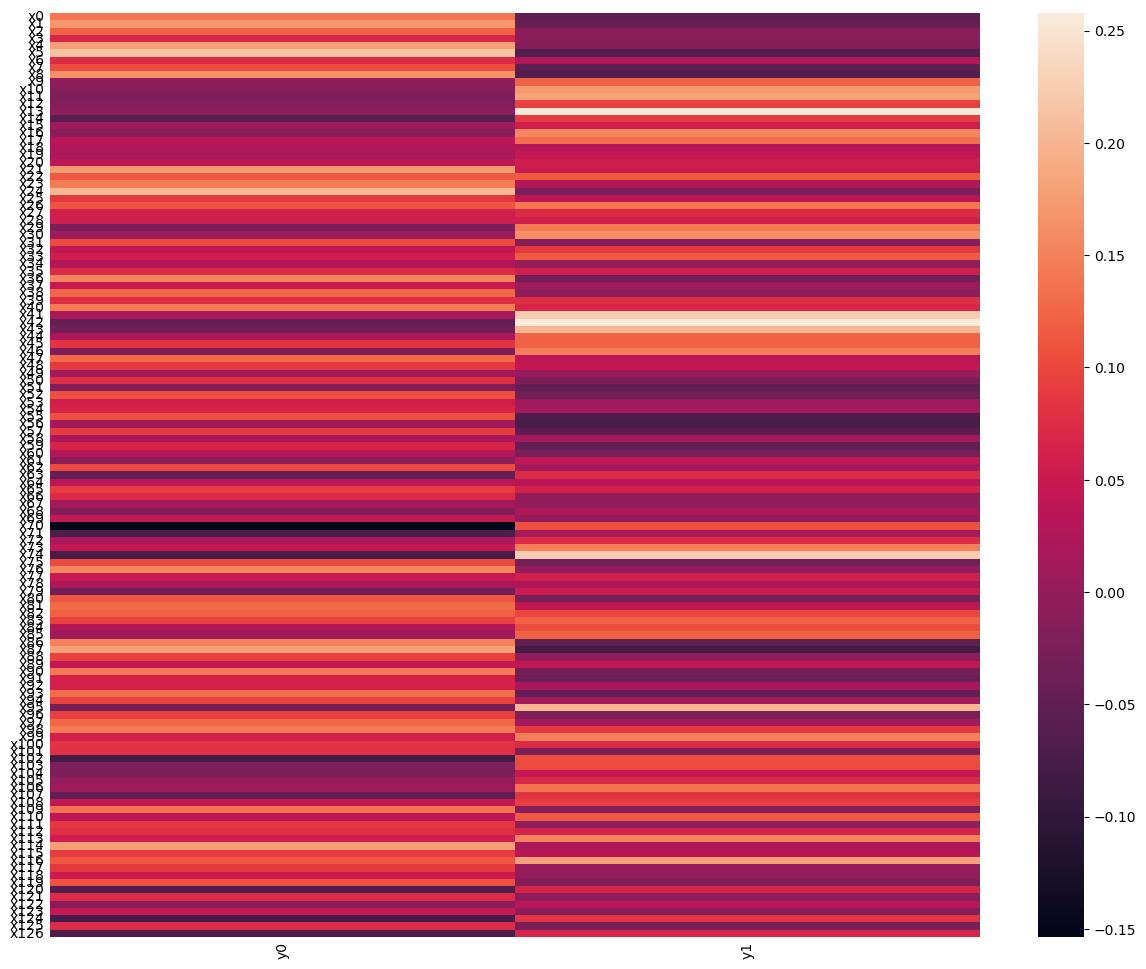

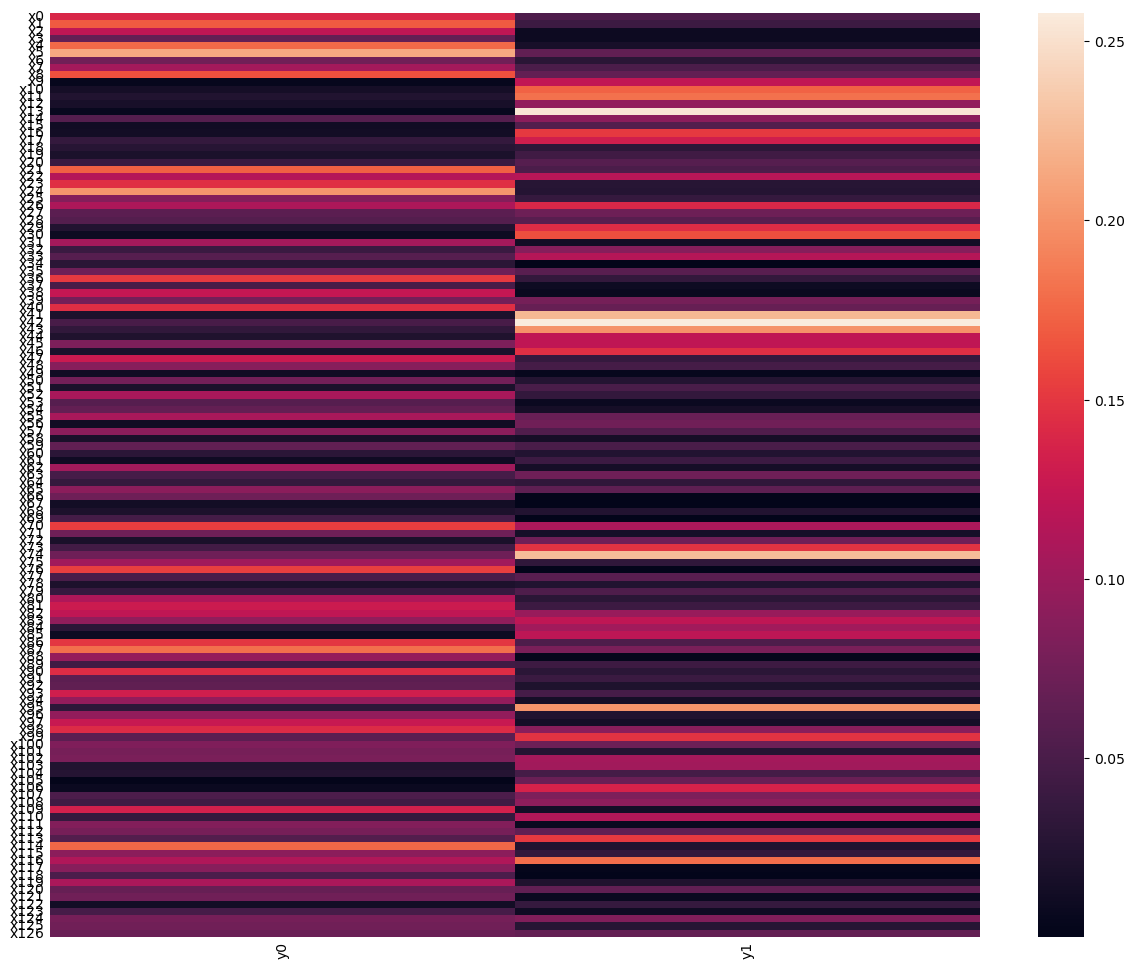

In [49]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [50]:
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.1398 * x0 + 0.1692 * x1 + 0.1215 * x2 + 0.0667 * x3 + 0.1771 * x4 + 0.2142 * x5 + 0.0738 * x6 + 0.1040 * x7 + 0.1638 * x8 - 0.0045 * x9 - 0.0152 * x10 - 0.0230 * x11 - 0.0164 * x12 - 0.0060 * x13 - 0.0570 * x14 + 0.0118 * x15 - 0.0125 * x16 + 0.0362 * x17 + 0.0271 * x18 + 0.0189 * x19 + 0.0395 * x20 + 0.1716 * x21 + 0.1146 * x22 + 0.1452 * x23 + 0.2018 * x24 + 0.0863 * x25 + 0.1105 * x26 + 0.0612 * x27 + 0.0567 * x28 - 0.0238 * x29 + 0.0100 * x30 + 0.1051 * x31 + 0.0399 * x32 + 0.0582 * x33 + 0.0284 * x34 + 0.0735 * x35 + 0.1521 * x36 + 0.0486 * x37 + 0.1249 * x38 + 0.0766 * x39 + 0.1448 * x40 + 0.0200 * x41 - 0.0493 * x42 - 0.0334 * x43 + 0.0223 * x44 + 0.0824 * x45 - 0.0187 * x46 + 0.1287 * x47 + 0.0880 * x48 + 0.0119 * x49 + 0.0762 * x50 - 0.0183 * x51 + 0.1069 * x52 + 0.0579 * x53 + 0.0662 * x54 + 0.1078 * x55 + 0.0116 * x56 + 0.0902 * x57 + 0.0173 * x58 + 0.0652 * x59 + 0.0297 * x60 - 0.0103 * x61 + 0.1030 * x62 - 0.0482 * x63 + 0.0360 * x64 + 0.0901 * x65 + 0.0729 * x66 + 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_12208/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


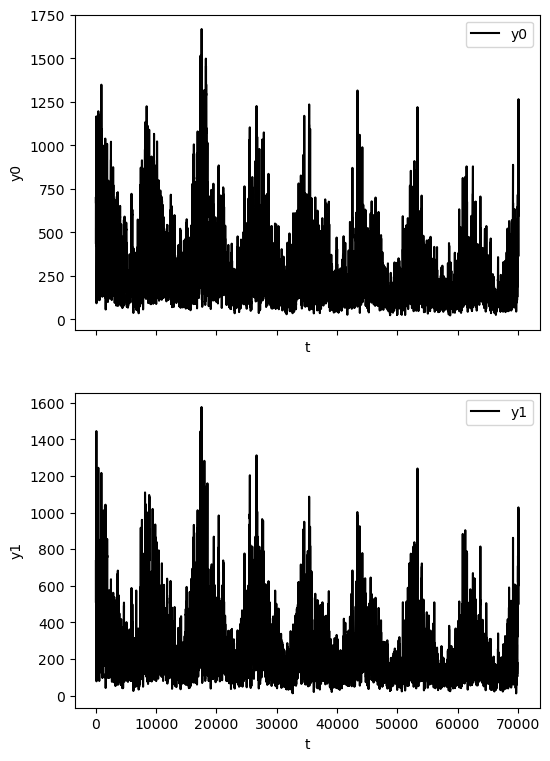

In [51]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()